# LR finder

In [1]:
import os

if "models" in os.getcwd():
    os.chdir("..")

if "notebooks" in os.getcwd():
    os.chdir("..")
os.getcwd()

'/home/jordi/Documents/GitHub/zebra_fish'

In [2]:
from src.dataset import register_default_datasets
from src.LrFinder import LRFinder
from src.RandomZoom import RandomZoom

#detectron
from detectron2.utils.events import EventStorage
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, build_detection_test_loader, build_detection_train_loader, DatasetMapper, detection_utils as utils, transforms as T
from detectron2.utils.events import CommonMetricPrinter, JSONWriter, TensorboardXWriter
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import CallbackHook
from detectron2.engine.hooks import HookBase
import detectron2.utils.comm as comm
from detectron2.utils.logger import log_every_n_seconds
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from pathlib import Path

import time
import datetime
import torch
import numpy as np
from torch.optim.lr_scheduler import LambdaLR
import shutil

register_default_datasets()

## Utils

In [3]:
class LRFinderSchedular(LambdaLR):
    def __init__(self,
        optimizer,
        start_lr: float = 1e-7,
        end_lr: float = 10,
        num_it: int = 1000,
    ) -> None:
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_it = num_it
        self.scheduled_lrs = np.logspace(np.log10(start_lr), np.log10(end_lr), num_it)

        for param_group in optimizer.param_groups:
            param_group["lr"] = 1
        
        super(LRFinderSchedular, self).__init__(optimizer, self._lr_lambda_, last_epoch=-1)

    def _lr_lambda_(self, epoch: int):
        return self.scheduled_lrs[epoch]

In [4]:
class CustomTrainer(DefaultTrainer):

    def __init__(self, cfg):
        super().__init__(cfg)



    @classmethod
    def build_train_loader(cls, cfg):
        augmentations = [
            T.RandomRotation([0, 365], expand=False, center=[[0.45, 0.45], [0.55, 0.55]], sample_style="range"),
            RandomZoom([[x, x] for x in np.linspace(0.40, 0.95, 10)], prob=0.25),
            T.RandomFlip(prob=0.5, horizontal=True),
            T.ResizeShortestEdge(short_edge_length=cfg.INPUT.MIN_SIZE_TRAIN, max_size=cfg.INPUT.MAX_SIZE_TRAIN, sample_style=cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING),
        ]
        mapper = DatasetMapper(
            is_train=True,
            augmentations=augmentations,
            image_format=cfg.INPUT.FORMAT,
            use_instance_mask=cfg.MODEL.MASK_ON,
            instance_mask_format=cfg.INPUT.MASK_FORMAT,
            use_keypoint=cfg.MODEL.KEYPOINT_ON,
            recompute_boxes=True,
        )

        return build_detection_train_loader(cfg, mapper=mapper)
    
            

## Settings

In [5]:
# Default config
use_collapsed = True
cfg = get_cfg()
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train",) if not use_collapsed else ("train_collapsed",)
cfg.DATASETS.TEST = ("val",) if not use_collapsed else ("val_collapsed",)
meta_dataset = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(meta_dataset.thing_classes)


print(meta_dataset.thing_classes)

cfg.MODEL.WEIGHTS = str(Path("./outputs/new_dataset/res101_fr2_no_problamatic_10000_random_zoom/model_final.pth"))
cfg.SOLVER.CHECKPOINT_PERIOD = 250
cfg.SOLVER.MAX_ITER = 1000
cfg.TEST.EVAL_PERIOD = 40
cfg.OUTPUT_DIR = "./outputs/new_dataset/res50_fr2_no_problamatic_10000_random_zoom"
cfg.MODEL.BACKBONE.FREEZE_AT = 2
cfg.SOLVER.WARMUP_ITERS = 0
if cfg.SOLVER.WARMUP_ITERS > 0:
    cfg.SOLVER.WARMUP_FACTOR = 1.0 / cfg.SOLVER.WARMUP_ITERS

# Hyper-params
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.RPN.NMS_THRESH = 0.70
cfg.SOLVER.WEIGHT_DECAY = 0.001
cfg.SOLVER.BASE_LR =  0.0012328467394420682



#cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.25, 0.5, 1.0, 2, 4]]
#cfg.INPUT.MIN_SIZE_TRAIN = (1333, 1333)
#cfg.INPUT.MAX_SIZE_TRAIN = 1333
#cfg.INPUT.MIN_SIZE_TEST = (1333, 1333)
#cfg.INPUT.MAX_SIZE_TEST = 1333
cfg.MODEL.RPN.LOSS_WEIGHT = 2.0
#cfg.MODEL.RESNETS.NORM = "BN"

assert cfg.TEST.EVAL_PERIOD % 20 == 0, "EVAL_PERIOD must be a multiple of 20"

['Healthy', 'Deformed', 'Death', 'Yolk']


[08/18 14:09:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (4, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (4,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (12, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (4, 256, 1, 1) in th

[08/18 14:09:24 d2.data.dataset_mapper]: Augmentations used in training: [RandomRotation(angle=[0, 365], expand=False, center=[[0.45, 0.45], [0.55, 0.55]]), RandomZoom(zooms=[[0.4, 0.4],
 [0.46111111111111114, 0.46111111111111114],
 [0.5222222222222223, 0.5222222222222223],
 [0.5833333333333333, 0.5833333333333333],
 [0.6444444444444444, 0.6444444444444444],
 [0.7055555555555555, 0.7055555555555555],
 [0.7666666666666666, 0.7666666666666666],
 [0.8277777777777777, 0.8277777777777777],
 [0.8888888888888888, 0.8888888888888888],
 [0.95, 0.95]], prob=0.25), RandomFlip(prob=0.5), ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice')]
[08/18 14:09:25 d2.data.build]: Removed 0 images with no usable annotations. 51 images left.
[08/18 14:09:25 d2.data.common]: Serializing 51 elements to byte tensors and concatenating them all ...
[08/18 14:09:25 d2.data.common]: Serialized dataset takes 0.49 MiB
[08/18 14:09:25 d2.data.build]: Using trainin

 67%|██████▋   | 67/100 [00:29<00:14,  2.27it/s]


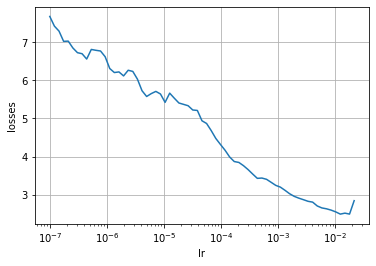

lr_steep = 9.326033468832199e-07 lr_min = 0.0012328467394420682


In [6]:
resume = False
cfg.OUTPUT_DIR = "./outputs/lr_finder"
cfg.SOLVER.BASE_LR = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
assert resume or len(os.listdir(cfg.OUTPUT_DIR))  == 0, "Output dir is not empty!"
assert cfg.SOLVER.BASE_LR == 1, "Base lr must be equal to 1."

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=resume)


finder = LRFinder(
    start_lr=1e-7,
    end_lr=10,
    beta=0.9, 
    num_it=100
)
        
with EventStorage(0) as trainer.storage:
    res = finder.find(
        trainer.model,
        trainer.optimizer,
        trainer.build_train_loader(trainer.cfg),
    )
res.plot()

print(f"lr_steep = {res.lr_steep} lr_min = {res.lr_min}")
shutil.rmtree(cfg.OUTPUT_DIR)
